# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


# Homework 2

# Convolutional Autoencoder
***

## Libraries

In [3]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [4]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


## Dataset
***

Before downloading the datasets I define a composed transformation to be applied on the elements of the dataset. The data are transformed to tensors and normalized such that their values goes from -1 to 1.

In [5]:
initial_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(0.5,0.5)])

In [6]:
data_dir = 'data/'

train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=initial_transform)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform=initial_transform)

N_val = int(len(train_dataset)*0.2)
train_dataset_red, val_dataset = random_split(train_dataset, 
                                 lengths=[len(train_dataset)-N_val, N_val], 
                                 generator=torch.Generator().manual_seed(42))
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
train_dataloader_red = DataLoader(train_dataset_red, batch_size=100, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset, batch_size=100, shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset, batch_size=100, shuffle=True, num_workers=0)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Network Definition
***

Here I define a Convolutional Neural Network, and its functions to train and test the model.
The convolutional Autoencoder is composed of:

**Encoder**:
* `Conv2d` layer with 1 channel in input (images are grayscale) and 16 channels in output. 3x3 kernel, stride=2, padding=1 to reduce the sample size from 28x28 to 14x14. The activation function of the layer is `ReLU`.
* Second `Conv2d` layer with 16 channel in input and 32 channels in output. 3x3 kernel, stride=2, padding=1 to reduce the sample size from 14x14 to 7x7 . Again the activation function is a `ReLU`.
* Last `Conv2d` layer with 32 channels in input and 64 in output with a kernel 7x7, such that each channels correspond to a single value

**Decoder**: Has the same structure of the Encoder, but reversed, composed of 3 `ConvTranspose2d` that goes from 64 to 32 to 16 to 1.
At the end the output is fed to a `Tanh` layer to have the data inside [-1,1] range.

In [109]:
class ConvAutoencoder(nn.Module):
    
    def __init__(self, latent_dim):
        super().__init__()
        
        ## Encoder
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, latent_dim, 7) # N, 64, 1, 1
        )
        
        ## Decoder
        # N, 64, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Tanh()  
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
### Training cycle function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    model.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    foo = tqdm(dataloader)
    for image_batch, _ in foo: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode-Decode data
        decoded_data = model(image_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        foo.set_description('Train batch loss: %f' % (loss.data))

### Testing cycle function
def test_epoch(model, device, dataloader, loss_fn):
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        val_loss = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode-Decode data
            decoded_data = model(image_batch)
            # Batch loss
            loss_batch = loss_fn(decoded_data, image_batch)
            # Append the loss
            val_loss.append(loss_batch.detach().cpu().numpy())
    return np.mean(val_loss)

### Trainer
def run_training(model, num_epochs, train_dataloader, val_dataloader, optim, loss_fn, device):
    model.to(device)
    for epoch in range(num_epochs):
        print('EPOCH %d/%d' % (epoch + 1, num_epochs))
        ### Training
        train_epoch(
            model=model,
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        ### Validation  (use the testing function)
        val_loss = test_epoch(
            model=model,
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        # Print Validationloss
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

        ### Plot progress
        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[0][0].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec_img  = model(img)
        # Plot the reconstructed image
        fig, axs = plt.subplots(1, 2, figsize=(6,3))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        plt.show()
        plt.close()

        # Save network parameters
        torch.save(model.encoder.state_dict(), 'encoder_params.pth')
        torch.save(model.decoder.state_dict(), 'decoder_params.pth')

## Trial Network
***

Now I define and train a simple network to test if everything works fine.
We fix the dimension of the latent space equal to 5.

The loss function will be the `MSELoss` because we want that the reconstructed image is as similar as possible to the original one.

The optimizer (Adam) is initialized in order to optimize both encorder and decoder.

In [110]:
## Test if the dimensions are fine
latent_dim = 5
ConvAut = ConvAutoencoder(latent_dim)

img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = ConvAut.encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = ConvAut.decoder(img_enc)
print('Decoded image shape:', dec_img.shape)
# Autoencode the image
aut_img = ConvAut(img)
print('Autoencoded image shape:', aut_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 5, 1, 1])
Decoded image shape: torch.Size([1, 1, 28, 28])
Autoencoded image shape: torch.Size([1, 1, 28, 28])


In [111]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
latent_dim = 10
ConvAut = ConvAutoencoder(latent_dim)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer 
params_to_optimize = [
    {'params': ConvAut.encoder.parameters()},
    {'params': ConvAut.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=5e-4, weight_decay=1e-5)

EPOCH 1/5


Train batch loss: 0.082895: 100%|██████████| 600/600 [00:13<00:00, 44.59it/s]




	 VALIDATION - EPOCH 1/5 - loss: 0.084572




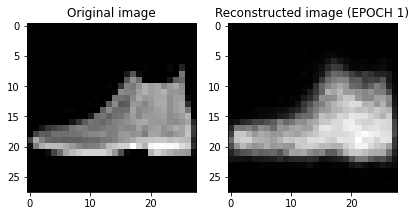

EPOCH 2/5


Train batch loss: 0.073926: 100%|██████████| 600/600 [00:13<00:00, 43.96it/s]




	 VALIDATION - EPOCH 2/5 - loss: 0.071564




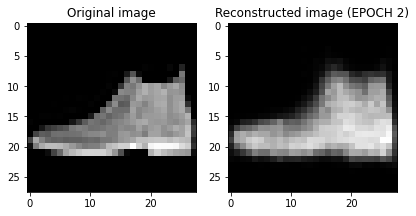

EPOCH 3/5


Train batch loss: 0.064746: 100%|██████████| 600/600 [00:14<00:00, 42.11it/s]




	 VALIDATION - EPOCH 3/5 - loss: 0.067165




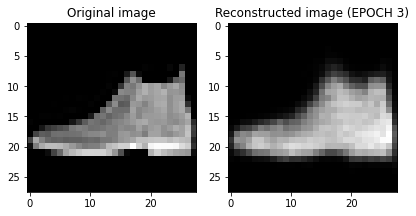

EPOCH 4/5


Train batch loss: 0.065913: 100%|██████████| 600/600 [00:13<00:00, 43.81it/s]




	 VALIDATION - EPOCH 4/5 - loss: 0.064248




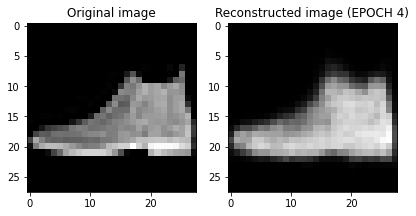

EPOCH 5/5


Train batch loss: 0.061989: 100%|██████████| 600/600 [00:13<00:00, 44.17it/s]




	 VALIDATION - EPOCH 5/5 - loss: 0.062665




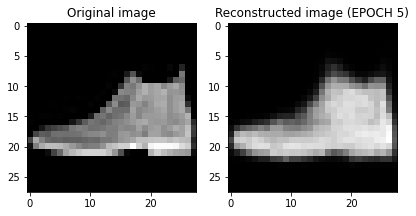

In [112]:
run_training(ConvAut, 5, train_dataloader, test_dataloader, optim, loss_fn, device)

We can already see that the reconstructed images are quite similar to the original ones. As usual let's see if we can improve.


### Hyperparameter tuning
***

Now I want to find the best set of hyperparameter for the model, so I will perform a (random) GridSearch on:
* Latent space dimension
* Weight regularization
* Learning Rate
* optimizer

In [32]:
def HPSampler(hp_dict):
    out = dict()
    for key, value in hp_dict.items():
        out[key] = np.random.choice(value)
    return out

def ModelFromHP(net_model, hyper_param, device):
    '''
    Initialize the Network and build the parameter dictionary
    ---
    net_model   - nn.Module
    hyper_param - dictionary with the actual hyperparameter
    device      - torch.device
    '''
    latent_dim  = hyper_param['latent_dim']
    wd   = hyper_param['wd']
    lr   = hyper_param['lr']
    ep   = hyper_param['epochs']
    ## Network Initialization
    actual_net = net_model(latent_dim)
    params_to_optimize = [
        {'params': actual_net.encoder.parameters()},
        {'params': actual_net.decoder.parameters()}
    ]
    
    if (hyper_param['optim'] == 'sgd'):
        optimizer = torch.optim.SGD(params_to_optimize, lr=lr, weight_decay=wd, momentum=0.9)
    elif (hyper_param['optim'] == 'adam'):
        optimizer = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=wd)
    else :
        print('Wrong optimizer')
    return actual_net, {'epochs' : ep,
                        'device' : device,
                        'loss_fn' : nn.MSELoss(),
                        'optimizer' : optimizer}

def GridSearch(net_model, train_dataloader, val_dataloader, hp_dict, N, device):
    '''
    RANDOM GRID SEARCH
    -----
    net_model        - nn.Module
    train_dataloader - Dataloader of training data
    val_dataloader   - Dataloader of validation data
    hp_dict          - dictionary of the hyperparameter on 
                       which perform grid search
    N                - number of different configuration to try
    device           - torch.device
    '''
    models = []
    best_loss = 1000
    for config in range(N):
        # Sample the hyperparameter configuration
        actual_hp = HPSampler(hp_dict)
        # Initialize the net
        actual_net, actual_params = ModelFromHP(net_model, actual_hp, device)
        
        # Train the model
        actual_net.to(device)
        optimizer = actual_params['optimizer']
        val_loss_config = []
        fuzz = tqdm(range(actual_params['epochs']))
        for epoch in fuzz:
            actual_net.train()
            # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
            for image_batch, _ in train_dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
                # Move tensor to the proper device
                image_batch = image_batch.to(device)
                # Encode-Decode data
                decoded_data = actual_net(image_batch)
                # Evaluate loss
                loss = loss_fn(decoded_data, image_batch)
                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # Print batch loss
                fuzz.set_description('Epoch: %2i, Train batch loss: %f' % (epoch+1, loss.data))
            
            # Validation
            actual_net.eval()
            with torch.no_grad():
                val_loss = []
                for image_batch, _ in val_dataloader:
                    # Move tensor to the proper device
                    image_batch = image_batch.to(device)
                    # Encode-Decode data
                    decoded_data = actual_net(image_batch)
                    # Batch loss
                    loss_batch = loss_fn(decoded_data, image_batch)
                    # Append the loss
                    val_loss.append(loss_batch.detach().cpu().numpy())
                    fuzz.set_description('Epoch: {:2n}, Validation batch loss: {:6.3f}'.format(epoch+1, loss_batch.data))
            val_loss_config.append(np.mean(val_loss))
            fuzz.set_description('Model: {:2n}, Final validation Loss: {:6.3f}'.format(config, val_loss_config[-1]))
        
        if (val_loss_config[-1] < best_loss): 
            best_loss = val_loss_config[-1]
            best_model = config
        models.append({'hp_dict'   : actual_hp,
                       'val_loss'  : val_loss_config})
    return models, best_model

In [20]:
hyper_dict = {'latent_dim': [8,32,64],
              'lr'    : np.linspace(5e-5,1e-3,100),
              'wd'    : np.linspace(1e-6,1e-4,100),
              'optim' : ['sgd', 'adam'],
              'epochs': [10]}

In [21]:
model_list, best_model = GridSearch(ConvAutoencoder, train_dataloader_red, val_dataloader, hyper_dict, 20, device)

Model: 19, Final validation Loss:  0.064: 100%|██████████| 10/10 [02:08<00:00, 12.84s/it]


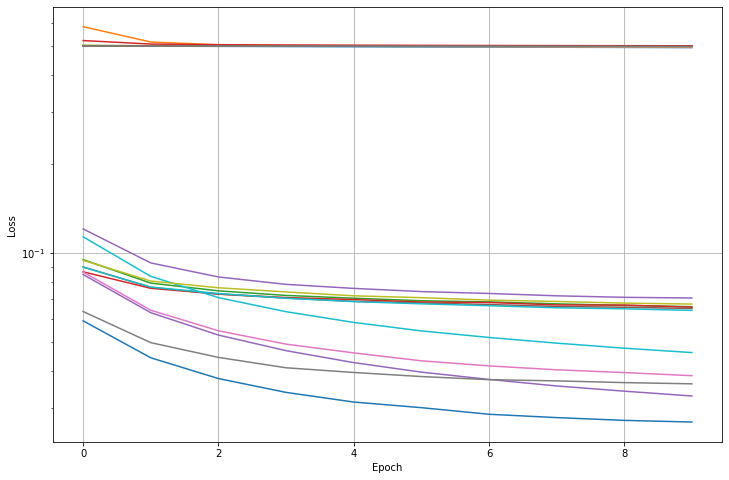

BEST MODEL HYPERPARAMETERS:
{'latent_dim': 64, 'lr': 0.0008272727272727273, 'wd': 5.6000000000000006e-05, 'optim': 'adam', 'epochs': 10}


In [22]:
plt.figure(figsize=(12,8))
for model in model_list:
    plt.semilogy(model['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()
print('BEST MODEL HYPERPARAMETERS:')
print(model_list[best_model]['hp_dict'])

## Best Model
***

Let's initialize a Network with the the best hyperparameter found by GridSearch.
Then I will train it and later tests it's performances.

EPOCH 1/10


Train batch loss: 0.054065: 100%|██████████| 600/600 [00:15<00:00, 38.52it/s]




	 VALIDATION - EPOCH 1/10 - loss: 0.056358




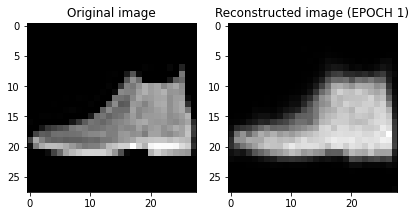

EPOCH 2/10


Train batch loss: 0.045872: 100%|██████████| 600/600 [00:14<00:00, 40.99it/s]




	 VALIDATION - EPOCH 2/10 - loss: 0.042527




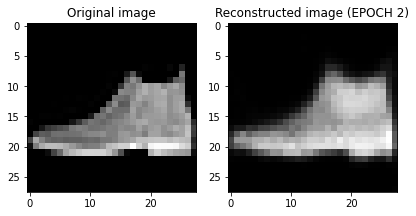

EPOCH 3/10


Train batch loss: 0.033406: 100%|██████████| 600/600 [00:18<00:00, 33.07it/s]




	 VALIDATION - EPOCH 3/10 - loss: 0.036001




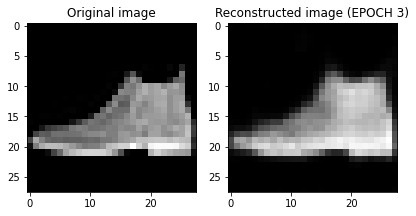

EPOCH 4/10


Train batch loss: 0.031448: 100%|██████████| 600/600 [00:17<00:00, 34.76it/s]




	 VALIDATION - EPOCH 4/10 - loss: 0.032223




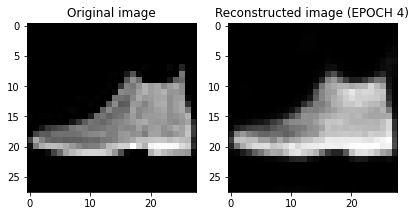

EPOCH 5/10


Train batch loss: 0.029746: 100%|██████████| 600/600 [00:14<00:00, 41.25it/s]




	 VALIDATION - EPOCH 5/10 - loss: 0.030000




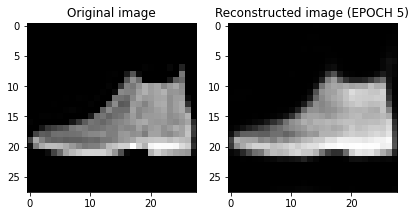

EPOCH 6/10


Train batch loss: 0.025170: 100%|██████████| 600/600 [00:15<00:00, 38.90it/s]




	 VALIDATION - EPOCH 6/10 - loss: 0.028485




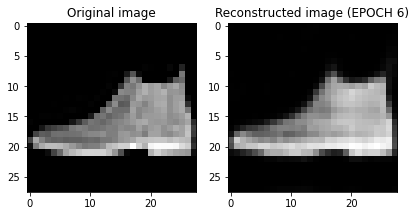

EPOCH 7/10


Train batch loss: 0.028849: 100%|██████████| 600/600 [00:15<00:00, 39.51it/s]




	 VALIDATION - EPOCH 7/10 - loss: 0.027873




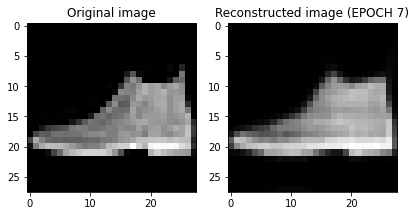

EPOCH 8/10


Train batch loss: 0.025986: 100%|██████████| 600/600 [00:15<00:00, 37.92it/s]




	 VALIDATION - EPOCH 8/10 - loss: 0.027349




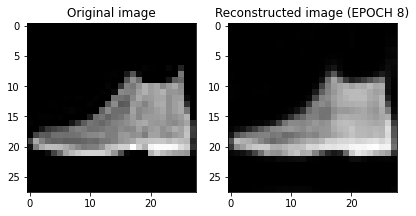

EPOCH 9/10


Train batch loss: 0.023733: 100%|██████████| 600/600 [00:14<00:00, 40.27it/s]




	 VALIDATION - EPOCH 9/10 - loss: 0.026577




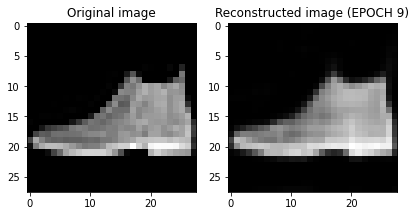

EPOCH 10/10


Train batch loss: 0.025291: 100%|██████████| 600/600 [00:14<00:00, 40.59it/s]




	 VALIDATION - EPOCH 10/10 - loss: 0.026473




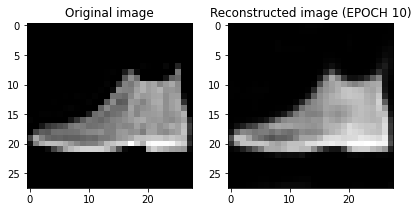

In [74]:
best_net, best_params = ModelFromHP(ConvAutoencoder, model_list[best_model]['hp_dict'], device)
run_training(best_net, best_params['epochs'], train_dataloader, test_dataloader, best_params['optimizer'], nn.MSELoss(), device)

The optimized network has a loss almost 3 time smaller than before. and the reconstructed image looks almost the same as the original one, just a little bit blurred.

## Fine Tuning - Transfer Learning
***

Now I want to verify if the knowledge learned by the encoder could be exploited by two new layer built on top of it, in order to classify the images.
I'm going to train a simple fully connected network to correctly classify the latent code produced by the pretrained encoder, based on the relative image from which it has been produced.

In [113]:
class Classifier(nn.Module):
    
    def __init__(self, pretrained_encoder):
        super().__init__()
        
        ## Encoder
        # N, 1, 28, 28
        self.encoder = pretrained_encoder # N, 64, 1, 1
        
        ## Actual Classifier
        self.fcBlock = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=self.encoder[4].out_channels, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fcBlock(x)
        return x

In [114]:
Model = Classifier(best_net.encoder)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(Model.fcBlock.parameters(), lr=1e-3, weight_decay=1e-4)

In [115]:
## Training
Model.to(device)
num_epoch = 30
train_loss_log = []
val_loss_log = []
for epoch in range(num_epoch):
    Model.train()
    train_loss = []
    foo = tqdm(train_dataloader)
    for sample_batched in foo: 
        # Move tensor to the proper device
        image_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        prediction = Model(image_batch)
        # Evaluate loss
        loss = loss_fn(prediction, label_batch)
        # Backward pass
        optim.zero_grad()
        loss.backward()
        optim.step()
        # Print batch loss
        foo.set_description('Epoch: {:2n}, Train batch loss: {:f}'.format(epoch+1, loss.data))
        # Save val loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
    train_loss_log.append(np.mean(train_loss))
        
    Model.eval()
    val_loss = []
    with torch.no_grad():
        for sample_batched in val_dataloader:
            # Move data to device
            image_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            # Forward pass
            prediction = Model(image_batch)

            # Compute loss
            loss = loss_fn(prediction, label_batch)

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
    val_loss_log.append(np.mean(val_loss))

Epoch: 30, Train batch loss: 0.249116: 100%|██████████| 600/600 [00:12<00:00, 46.47it/s]


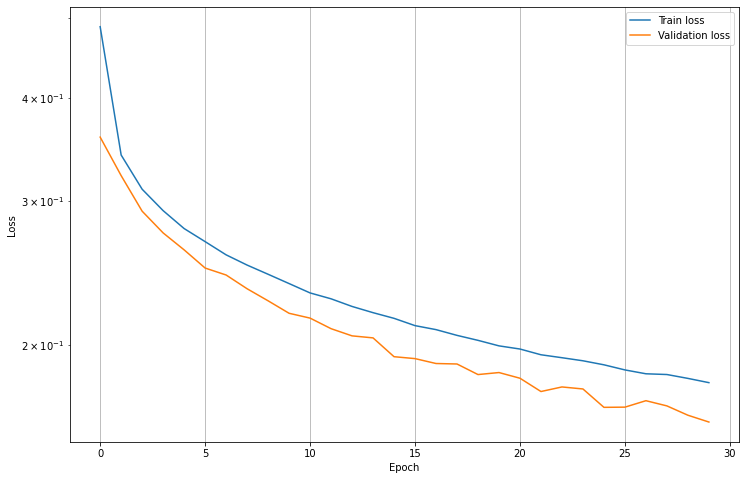

In [116]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [117]:
## Test the model
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
Model.eval()
with torch.no_grad(): # turn off gradients computation
    label_list = []
    pred_list = []
    for sample_batched in tqdm(test_dataloader):
        # Move data to device
        image_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].detach().cpu().numpy()

        # Forward pass
        out = Model(image_batch)
        pred_batch = out.detach().cpu().numpy().argmax(1)
        label_list.append(label_batch)
        pred_list.append(pred_batch)

print(f'Accuracy of the network on the 10000 test images: {100 * np.equal(label_list,pred_list).sum() // len(pred_list)} %')

100%|██████████| 10000/10000 [00:11<00:00, 872.33it/s]

Accuracy of the network on the 10000 test images: 89 %


After a short training the new classifier was able to do its job with a 89% accuracy: a stunning result compared to the performance of the convolutional classifier build in the first homework, which reached a 90% accuracy just after the hyperparameter optimization and a long training. 

Obviuously the lunch is still not free, most of the job it has been done by the encoder in its training.

## Latent Space
***

In [81]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    best_net.eval()
    with torch.no_grad():
        encoded_img  = best_net.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.head()

100%|██████████| 10000/10000 [00:11<00:00, 857.15it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 55,Enc. Variable 56,Enc. Variable 57,Enc. Variable 58,Enc. Variable 59,Enc. Variable 60,Enc. Variable 61,Enc. Variable 62,Enc. Variable 63,label
0,0.646157,-0.130067,-1.538222,3.757751,-4.081848,-2.813043,0.420642,-1.609208,-4.753785,-2.424034,...,0.201761,0.731938,1.075914,-2.098765,-0.406429,0.976011,3.403068,-0.986529,-3.225287,9
1,-2.481985,-19.802166,-0.761514,-0.846228,1.345550,-1.786054,0.706849,-4.092294,-1.060382,0.903238,...,1.743338,6.230525,1.058183,0.367783,-0.623904,-3.422011,-0.711257,-0.220504,-1.486811,2
2,5.287377,-0.796028,-2.726777,1.836623,1.564836,1.303406,1.340218,0.025077,1.286769,0.128988,...,3.108651,-1.989487,1.238595,-1.579413,-2.367240,-3.067536,-1.409485,1.507441,-3.997790,1
3,2.237303,1.831609,1.380420,2.255300,-1.464733,-0.967595,-1.243548,-0.754722,4.086702,0.351315,...,0.869934,0.590542,0.437994,-2.735563,1.786444,0.035346,1.088704,1.808082,-1.820926,1
4,0.009447,-8.059995,-0.210043,1.657338,-1.804011,-2.480215,-2.139132,-0.502363,2.284680,-0.509965,...,3.618364,1.279942,-4.017439,1.143595,1.236321,0.901689,2.342854,-2.685942,1.562196,6


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


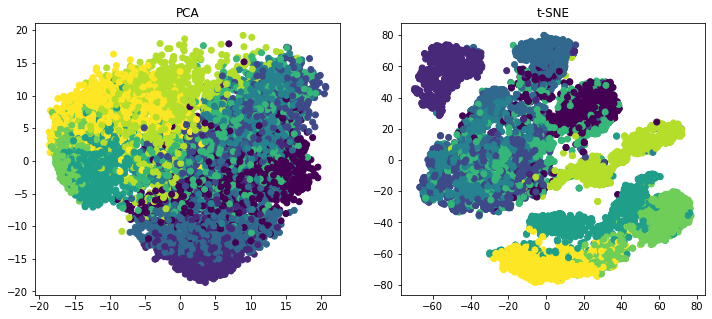

In [82]:
## PCA
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)

## TSNE
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())
ax[0].set_title('PCA')
ax[1].scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())
ax[1].set_title('t-SNE')
plt.show()

The clustering of the laten codes is better performed, as aspected, by the t-SNE.
It can be seen that the different "communities" are pretty separated between each others, obviously someone more than other. This mean that two latent code corresponding to the same label are closer than two latent code corresponding to different labels. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


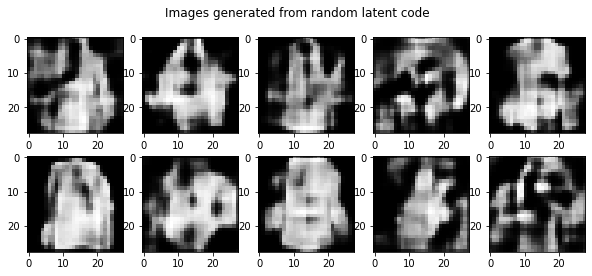

In [107]:
latent_dim = model_list[best_model]['hp_dict']['latent_dim']
random_latent = np.zeros((10,latent_dim))
for feature in range(latent_dim):
    mean = encoded_samples.iloc[:,feature].values.mean()
    std  = encoded_samples.iloc[:,feature].values.std()
    for ii in range(10):
        random_latent[ii, feature] = np.random.normal(mean, std)
    
fig, ax = plt.subplots(2,5, figsize=(10,4))

for ii,sample in enumerate(random_latent):
    best_net.eval()
    with torch.no_grad():
        sample = torch.tensor(sample).reshape(1, latent_dim, 1, 1)
        generated_img = best_net.decoder(torch.tensor(sample.float()).to(device))
        ax[ii//5,ii%5].imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
plt.suptitle('Images generated from random latent code')
plt.show()

Here I reported some recontructed images, generated from a random latent code.


## GAN
***

## Network definition
***

The Generative Adversarial Network is composed of two separate entities: the generator and the discriminator.

* **Generator**: its structure resemble the decoder of the previously defined Autoencoder, but now I normalize the layer's output with `BatchNorm2d`.

* **Discriminator**: composed of 3 convolutional layer, each of one normalized by `BatchNorm2d` and activated with a `ReLU`, followed by another `Conv2d` feed into a `Sigmoid` to have a binary classification problem.

The generator is trained optimizing its ability to fools the disctiminator.
The discriminator is optimized to correcly determine if an image it's fake or real.

The loss function is the Binary Cross Entropy loss, because I am computing the loss always between the output of the discriminator and a label.
As optimizer I exploited Adam.

In [77]:
class Generator(nn.Module):
    
    def __init__(self, latent_dim):
        super().__init__()
        # N, latent_dim, 1, 1
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Tanh()  
        )
    
    def forward(self, x):
        x = self.main(x)
        return x
    
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.main = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # N, 64, 4, 4
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 4), # N, 1, 1, 1
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [78]:
latent_dim = 64
generator = Generator(latent_dim)
discriminator = Discriminator()

loss_fn = torch.nn.BCELoss()

optimizer_gen = torch.optim.Adam(generator.parameters(), lr=5e-4)
optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=1e-5)

In [79]:
def weights_init_normal(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(model.bias.data, 0.0)

generator.to(device)
discriminator.to(device)
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
generator.train()
discriminator.train()
## Training
num_epoch = 30
gen_loss_log = []
dis_loss_log = []
bar = tqdm(range(num_epoch))
for epoch in bar:
    gen_loss = []
    dis_loss = []
    for imgs, _ in train_dataloader:
        
        real_label = torch.from_numpy(np.ones((imgs.shape[0],1,1,1))).float().to(device)
        fake_label = torch.from_numpy(np.zeros((imgs.shape[0],1,1,1))).float().to(device)
        
        real_imgs = imgs.to(device)
        
        # Train generator
        fake_encode = torch.from_numpy(np.random.normal(0, 1, (imgs.shape[0], latent_dim, 1, 1))).float().to(device)
        fake_imgs = generator(fake_encode)
        
        gen_loss_batch = loss_fn(discriminator(fake_imgs), real_label) # Ablity to produce realistic imgs
        
        optimizer_gen.zero_grad()
        gen_loss_batch.backward()
        optimizer_gen.step()
        
        # Train discriminator
        dis_real_loss_batch = loss_fn(discriminator(real_imgs), real_label) # Ability to recognize real images
        dis_fake_loss_batch = loss_fn(discriminator(fake_imgs.detach()), fake_label) # Ability to recognize real images
        dis_loss_batch = (dis_real_loss_batch + dis_fake_loss_batch) / 2
                                
        optimizer_dis.zero_grad()
        dis_loss_batch.backward()
        optimizer_dis.step()
        
        bar.set_description('Epoch: {:2n}, Gen_loss: {:6.3f}, Disc_real_loss: {:6.3f}, Disc_fake_loss: {:6.3f}'.format(epoch+1, gen_loss_batch.data, dis_real_loss_batch.data, dis_fake_loss_batch.data))
        gen_loss.append(gen_loss_batch.detach().cpu())
        dis_loss.append(dis_loss_batch.detach().cpu())
    gen_loss_log.append(np.mean(gen_loss))
    dis_loss_log.append(np.mean(dis_loss))


Epoch: 30, Gen_loss:  0.699, Disc_real_loss:  0.696, Disc_fake_loss:  0.688: 100%|██████████| 30/30 [08:15<00:00, 16.50s/it]


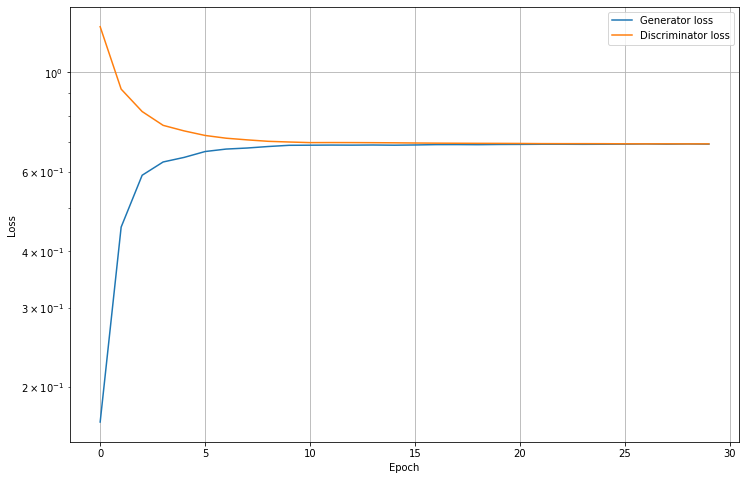

In [80]:
plt.figure(figsize=(12,8))
plt.semilogy(gen_loss_log, label='Generator loss')
plt.semilogy(dis_loss_log, label='Discriminator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

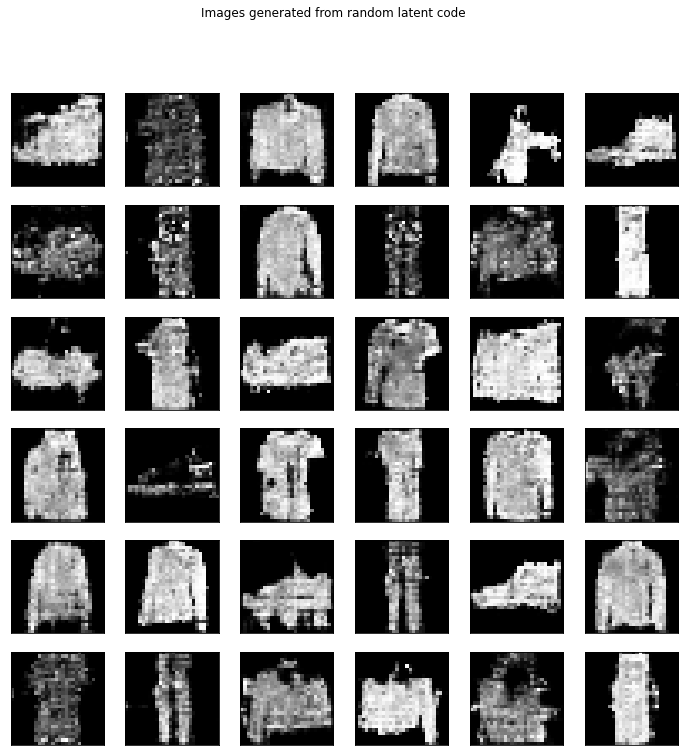

In [81]:
fig, ax = plt.subplots(6,6, figsize=(12,12))

with torch.no_grad():
    generator.eval()
    fake_encode = torch.from_numpy(np.random.normal(0, 1, (36, latent_dim, 1, 1))).float().to(device)
    for ii,sample in enumerate(fake_encode):
        fake_imgs = generator(sample.reshape(1,latent_dim,1,1))
        ax[ii//6, ii%6].imshow(fake_imgs.squeeze().cpu().numpy(), cmap='gist_gray')
        ax[ii//6, ii%6].set_yticks([])
        ax[ii//6, ii%6].set_xticks([])
plt.suptitle('Images generated from random latent code')
plt.show()

After some manual tweaking of hyperparameters I found the combination that makes the GAN converges to this results.

It can be seen that the training reached convergence. I have also reported some images generated by the GAN. The results are not optimal but there are some images that resembles cloths.